In [19]:
# packages
import pandas as pd
import duckdb 
import math

In [50]:
trusted_zone_db = '../data/trusted_zone/trusted_zone.db'
exploitation_zone_db = '../data/exploitation_zone/exploitation_zone.db'

In [5]:
def get_tables(conn):
    tables_lists = conn.sql("SHOW TABLES").fetchall()
    return [t[0] for t in tables_lists]

def table_exists(table_name, conn):
    return table_name in get_tables(conn)

def get_table_df(table_name, conn):
    return conn.sql(f"SELECT * FROM \"{table_name}\";").df()

def drop_table(table_name, conn):
    if table_exists(table_name, conn):
        conn.sql(f"DROP TABLE \"{table_name}\"")
    
def create_table(table_name, df, conn, replace=True):
    if replace & table_exists(table_name, conn): 
        drop_table(table_name, conn)
    conn.sql(f"CREATE TABLE \"{table_name}\" AS SELECT * FROM df")

def append_table(table_name, df, conn):
    conn.sql(f"INSERT INTO \"{table_name}\" SELECT * FROM df")

## Matching each football match to the closer weather
First we will link each team (with its stadium) to a weather stadium by choosing the closest one.

In [25]:
conn = duckdb.connect(trusted_zone_db)
stadiums_df = get_table_df('team_stadium_location',conn)
wstations_df = get_table_df('weather_station_locations',conn)

# NEED TO FIX COLUMN NAME FROM THE START AND DEELTE THIS 3 LINES
stadiums_df.rename(columns={'LON': 'TEMP'}, inplace=True)
stadiums_df.rename(columns={'LAT': 'LON'}, inplace=True)
stadiums_df.rename(columns={'TEMP': 'LAT'}, inplace=True)
conn.close()

In [34]:
stadiums_df.head()

,team_name,NAME,LAT,LON,closest_weather_station
0,Arsenal,Emirates Stadium,51.558920,-0.109781,Heathrow
1,Aston Villa,Villa Park,52.509203,-1.884718,Shawbury
2,Bournemouth,Vitality Stadium,50.734974,-1.839025,Hurn
3,Brentford,Gtech Gommunity Stadium,51.490959,-0.288670,Heathrow
4,Brighton,American Express Community Stadium,50.861748,-0.083706,Herstmonceux


In [33]:
wstations_df.head()

,SITE,LAT,LON
0,Lerwick,60.190187,-1.088959
1,Wick,58.463990,-3.081510
2,Stornoway,58.213929,-6.387110
3,Loch Glascarnoch,57.769856,-4.852771
4,Aviemore,57.258025,-3.868066


In [44]:
def euclidean_distance(lat1, lon1, lat2, lon2):
    # Assuming the Britain can be approximated as a flat plane, calculate the distance using Pythagoras' theorem
    lat_diff = lat2 - lat1
    lon_diff = lon2 - lon1
    distance = math.sqrt(lat_diff**2 + lon_diff**2)

    return distance

closest_stations = []

# Loop through each team
for i, team_row in stadiums_df.iterrows():
    min_distance = float('inf')
    closest_station = None

    # Loop through each weather station
    for j, weather_row in wstations_df.iterrows():        
        distance = euclidean_distance(team_row['LAT'], team_row['LON'], weather_row['LAT'], weather_row['LON'])
        if distance < min_distance:
            min_distance = distance
            closest_station = weather_row['SITE']
        
    closest_stations.append(closest_station)
    
stadiums_df['closest_weather_station'] = closest_stations

team_station_df = stadiums_df[['team_name', 'closest_weather_station']]
team_station_df

,team_name,closest_weather_station
0,Arsenal,Heathrow
1,Aston Villa,Shawbury
2,Bournemouth,Hurn
3,Brentford,Heathrow
4,Brighton,Herstmonceux
5,Burnley,Shap
6,Cardiff,Almondsbury
7,Chelsea,Heathrow
8,Crystal Palace,Heathrow
9,Everton,Crosby


### Plot of the weather stations and stadiums

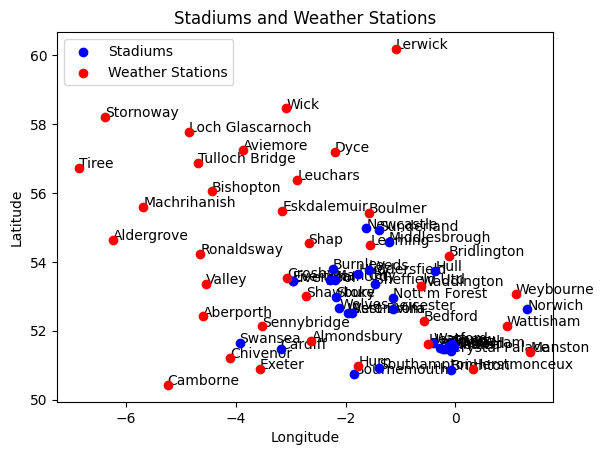

In [30]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.scatter(stadiums_df['LON'], stadiums_df['LAT'], c='blue', label='Stadiums', zorder=5)


for i, txt in enumerate(stadiums_df['team_name']):
    ax.annotate(txt, (stadiums_df['LON'].iloc[i], stadiums_df['LAT'].iloc[i]))

ax.scatter(wstations_df['LON'], wstations_df['LAT'], c='red', label='Weather Stations', zorder=5)

for i, txt in enumerate(wstations_df['SITE']):
    ax.annotate(txt, (wstations_df['LON'].iloc[i], wstations_df['LAT'].iloc[i]))

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Stadiums and Weather Stations")

ax.legend()
plt.show()

## Now matching each weather to each match

Now knowing which weather station is closer to which team we apply to every football match the weather of that day of its closest station. 

In [37]:
conn = duckdb.connect(trusted_zone_db)
met_df = get_table_df('Metoffice', conn)
football_matches_df = get_table_df('football-data', conn)
conn.close()

In [38]:
met_df.head()

,Date,Station_no,Station_name,PRESS,WDIR,WSPD,CLOUD,TEMP,TDEW
0,2022-07-01,1,Lerwick,1010.8,S,6.0,4.0,11.7,11.7
1,2022-07-01,2,Wick,1010.2,WSW,2.0,8.0,10.6,9.9
2,2022-07-01,3,Stornoway,1009.8,S,9.0,8.0,12.1,11.6
3,2022-07-01,4,Loch Glascarnoch,1011.5,WSW,3.0,6.0,7.3,5.3
4,2022-07-01,5,Aviemore,1011.4,nan,NaN,2.0,9.0,6.5


In [39]:
football_matches_df.head()

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,AvgC<2.5,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA
0,E0,2022-05-08,2023-10-21 20:00:00,Crystal Palace,Arsenal,0,2,A,0,1,...,1.76,0.50,2.09,1.84,2.04,1.88,2.09,1.88,2.03,1.85
1,E0,2022-06-08,2023-10-21 12:30:00,Fulham,Liverpool,2,2,D,1,0,...,2.73,1.75,1.90,2.03,1.91,2.02,2.01,2.06,1.89,1.99
2,E0,2022-06-08,2023-10-21 15:00:00,Bournemouth,Aston Villa,2,0,H,1,0,...,1.76,0.50,1.93,2.00,1.93,2.00,1.94,2.04,1.88,2.00
3,E0,2022-06-08,2023-10-21 15:00:00,Leeds,Wolves,2,1,H,1,1,...,1.87,-0.25,2.08,1.85,2.10,1.84,2.14,1.87,2.08,1.81
4,E0,2022-06-08,2023-10-21 15:00:00,Newcastle,Nott'm Forest,2,0,H,0,0,...,1.89,-1.00,1.97,1.96,1.99,1.93,2.19,1.97,2.03,1.86


In [40]:
football_matches_stations_df = football_matches_df.merge(team_station_df, 
                                               left_on='HomeTeam', 
                                               right_on='team_name', 
                                               how='left')


In [43]:
football_matches_stations_df[['HomeTeam', 'closest_weather_station']]

,HomeTeam,closest_weather_station
0,Crystal Palace,Heathrow
1,Fulham,Heathrow
2,Bournemouth,Hurn
3,Leeds,Leeming
4,Newcastle,Boulmer
...,...,...
375,Everton,Crosby
376,Leeds,Leeming
377,Leicester,Bedford
378,Man United,NaN


In [48]:
final_football_df = football_matches_stations_df.merge(met_df, 
                                           left_on=['Date', 'closest_weather_station'], 
                                           right_on=['Date', 'Station_name'],
                                            how='left')
# Drop the repeated columns
final_football_df = final_football_df.drop('team_name', axis=1)
final_football_df = final_football_df.drop('closest_weather_station', axis=1)
final_football_df = final_football_df.drop('Station_no', axis=1)
final_football_df = final_football_df.drop('Station_name', axis=1)

In [49]:
final_football_df.head()

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA,PRESS,WDIR,WSPD,CLOUD,TEMP,TDEW
0,E0,2022-05-08,2023-10-21 20:00:00,Crystal Palace,Arsenal,0,2,A,0,1,...,2.09,1.88,2.03,1.85,1028.7,E,7.0,7.0,12.2,9.2
1,E0,2022-06-08,2023-10-21 12:30:00,Fulham,Liverpool,2,2,D,1,0,...,2.01,2.06,1.89,1.99,1007.5,S,7.0,8.0,14.7,13.2
2,E0,2022-06-08,2023-10-21 15:00:00,Bournemouth,Aston Villa,2,0,H,1,0,...,1.94,2.04,1.88,2.00,1006.3,S,10.0,8.0,14.7,14.5
3,E0,2022-06-08,2023-10-21 15:00:00,Leeds,Wolves,2,1,H,1,1,...,2.14,1.87,2.08,1.81,1006.3,S,3.0,7.0,11.1,9.7
4,E0,2022-06-08,2023-10-21 15:00:00,Newcastle,Nott'm Forest,2,0,H,0,0,...,2.19,1.97,2.03,1.86,1006.6,SE,6.0,8.0,10.3,9.3


In [51]:
conn = duckdb.connect(trusted_zone_db)
players_info = cleaned_merged_seasons
conn.close()

['Metoffice', 'cleaned_merged_seasons', 'football-data', 'master_team_list', 'team_stadium_location', 'weather_station_locations']


In [ ]:
conn = duckdb.connect(exploitation_zone_db)
create_table('football_matches', final_football_df, conn)
create_table('', final_football_df, conn)

conn.close()